# Amazone Fine Food Review Analysis Logistic Regression

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

   Number of reviews: 568,454<br>
   Number of users: 256,059<br>
   Number of products: 74,258<br>
   Timespan: Oct 1999 - Oct 2012<br>
   Number of Attributes/Columns in data: 10 

Attribute Information:

   1. Id
   2. ProductId - unique identifier for the product
   3. UserId - unqiue identifier for the user
   4. ProfileName
   5. HelpfulnessNumerator - number of users who found the review helpful
   6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
   7. Score - rating between 1 and 5
   8. Time - timestamp for the review
   9. Summary - brief summary of the review
   10. Text - text of the review



In [1]:
#import re
#import nltk
#import string
#import pickle
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot.metrics as skplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
#from nltk.corpus import stopwords
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
import gensim
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

## Loading Data

In [2]:
con = sqlite3.connect("final.sqlite")
final = pd.read_sql_query("""SELECT * FROM Reviews""",con)

## Sorting data 

In [3]:
final.sort_values("Time",ascending=True, inplace=True, kind='quicksort')

##### Replace Negative with 0 and Positive with 1 

In [4]:
final['Score'].replace(['negative', 'positive'],[0,1],inplace=True)

In [5]:
final = final.to_csv("final.csv") #saving dataframe

In [6]:
final = pd.read_csv("final.csv") #retriving the sorted dataframe

In [7]:
final = final.iloc[:100000] #taking initial 100k points

## Function

In [8]:
# defining LR function that does cross validation , plotting Misclassification Error v/s C, accuracy, test accuracy 
# and confusion matrix
# this function takes 'algo', 'X_train', 'X_test', 'y_train', 'y_test' as arguments
def LR(search,X_train, X_test, y_train, y_test):
    
   
    #Normalize Data
    X_train = preprocessing.normalize(X_train)
    print("Train Data Size: ",X_train.shape)
    #Normalize Data
    X_test = preprocessing.normalize(X_test)
    print("Test Data Size: ",X_test.shape)
    
    #if(reg=='l1'):
    #    clf= 'l1'
    #elif(reg=='l2'):
    #    clf= 'l2'
    
    
    LR = LogisticRegression()
    param = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150, 200],'penalty':['l2','l1']} #params we need to try on classifier
    tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
    
    if(search=="Grid"):
        CV=GridSearchCV(estimator=LR, param_grid=param, verbose=1, cv=tscv)
    elif(search=="Random"):
        CV=RandomizedSearchCV(estimator=LR, param_distributions=param, cv=tscv,  verbose=1)
    
    #Finding the best k using Cross Validation
     
    gsv = CV
    gsv.fit(X_train,y_train)

    print("Best HyperParameter: ",gsv.best_params_)
    print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
    
   
    #plot error vs C
    x_1=[]
    x_2=[]
    y_1=[]
    y_2=[]
    for x in gsv.grid_scores_:
        if(x[0]['penalty']=='l1'):
            x_1.append(x[0]['C'])
            y_1.append(1-x[1])
        else:
            x_2.append(x[0]['C'])
            y_2.append(1-x[1])
    plt.plot(x_1,y_1, label='l1')
    plt.plot(x_2,y_2, label='l2')
    plt.xlabel('value of C')
    plt.ylabel('misclassification error')
    plt.title('C vs error')
    plt.legend()
    plt.show()
    
    #Testing Accuracy on Test data
    
    LR = LogisticRegression(C=gsv.best_params_['C'],penalty=gsv.best_params_['penalty'])
    LR.fit(X_train,y_train)
    y_pred = LR.predict(X_test)
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
    print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
    print("Non Zero weights:",np.count_nonzero(LR.coef_))
    print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
    
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')
    #skplt.plot_confusion_matrix(y_test ,y_pred)
    
    C = gsv.best_params_['C'] #for best C
    penalty = gsv.best_params_['penalty'] #for best penalty   
    
    return C, penalty


## Function for multiple sparsity

In [9]:
# sparsity increases as we increase lambda or decrease C when L1 Regularizer is used
# this function takes 'X_train', 'y_train','X_test','y_test' as arguments
def sparsity(X_train,y_train,X_test, y_test):
    
    w_change=[]
    C= [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 150]
    for x in C:
        LR=LogisticRegression(penalty='l1', C=x)
        LR.fit(X_train,y_train)
        accuracy = LR.predict(X_test)
        print('at C=',x)
        print('test error=',(1-accuracy_score(accuracy,y_test)))
        count=np.count_nonzero(LR.coef_)
        print('number of non zero element in w=', count)
        print('***********************************************')
        w_change.append(count)
        
        
    plt.figure(figsize=(6,6))
    plt.plot(C,w_change,color='green')
    plt.title('change in non zero element in W , when C changes')
    plt.xlabel('value of C')
    plt.ylabel('number of non zero element in W')
    plt.show()
        

## Function for Feature Importance 

In [10]:
#code borrowed from  https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def show_cloud(vectorizer, w, n=100):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(w[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    positive = []
    negative = []
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        #print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        positive.append(fn_2)
        negative.append(fn_1)
    positive = ' '.join(positive)
    
    #wordcloud for postitve word
    
    wordcloud  = WordCloud(max_font_size=40).generate(positive)
    plt.figure()
    plt.title("wordcloud for positive class words")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    print('*****************************************************')
    
    negative = ' '.join(negative)
   
    #wordcloud for negative word
    
    wordcloud  = WordCloud(max_font_size=40).generate(negative)
    plt.figure()
    plt.title("wordcloud for negative class words")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## 1.Bag Of Word 

   The bag-of-words model is a simplifying representation used in natural language processing and information retrieval(IR).Also known as the vector space model.The bag-of-words model is commonly used in methods of document classification where the occurrence of each word is used as a feature for training a classifier.OR
   Simply,Converting a collection of text documents to a matrix of token counts

In [11]:
X = final["CleanedText"] #taking cleandtext as X
y = final["Score"] #taking score as y

### 1.1  Grid

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:  4.7min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 92.60%


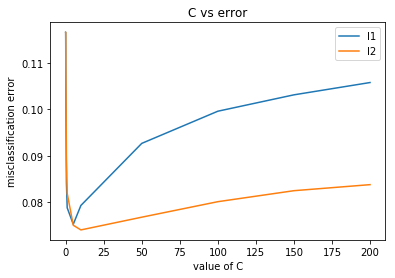

Accuracy on test set: 92.393%
Precision on test set: 0.939
Recall on test set: 0.975
F1-Score on test set: 0.957
Non Zero weights: 31377
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



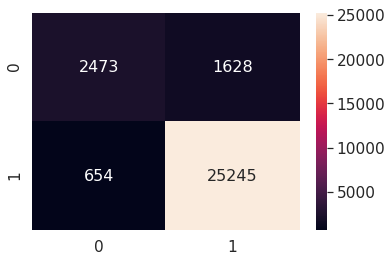

In [12]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

#Bag of Words
count = CountVectorizer() 

X_train = count.fit_transform(X_train)

X_test = count.transform(X_test)

C, penalty = LR(search="Grid",X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test)


In [13]:
#Normalize Data
X_train = preprocessing.normalize(X_train)

X_test = preprocessing.normalize(X_test)

### 1.1.1 Perturbation test 

In [14]:
clf = LogisticRegression(C= C, penalty= penalty)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
w=clf.coef_
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.393%
Non Zero weights: 31377


In [15]:
# for findind feature importance we need to check multicollinearity
# apply perturbation test for checking multicollinearity
# in perturbation test, we add some noise to the training data and the fit the model
# the w we will get after fittng the model, if it is significantly different than w which we get without any error adding then we will say it is multicollinear

X_train.data=X_train.data+np.random.normal(loc=0,scale=0.1,size=X_train.data.shape) #adding a noise with a very small value

In [16]:
#computing weight after perturbation weight
clf=LogisticRegression(C=C, penalty=penalty)
clf.fit(X_train,y_train)
w_=clf.coef_
print('number of non-zero element in w_=', np.count_nonzero(w_))

number of non-zero element in w_= 31377


In [17]:
#getting the number of elements in w which changes after perturbation test by more than 50%
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>30):
        cnt+=1
print('number of elements in w_delta,more than 30% =',cnt)

number of elements in w_delta,more than 30% = 24172


#### Observation-
* we have 31377 non zero elements in weight before perturbation
* after perturbation test, 24172 elements in weight before perturbation change by more than 30 %
* Thus we can say that elements weight are collinear

### 1.1.2 Word Cloud Feature Importance

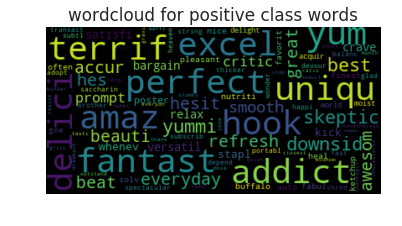

*****************************************************


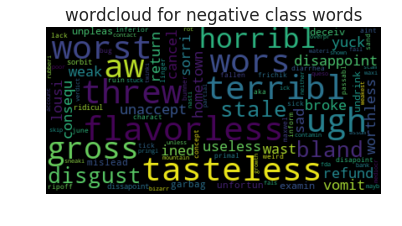

In [18]:
clf = LogisticRegression(C = C, penalty = penalty)
clf.fit(X_train,y_train)
show_cloud(count, clf.coef_)

### 1.2 Random

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1}
Best Accuracy: 92.12%


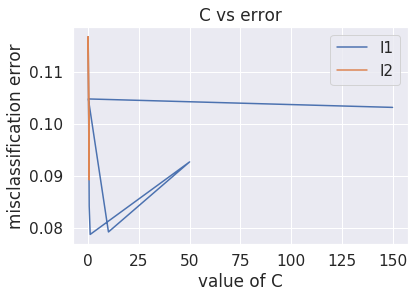

Accuracy on test set: 92.073%
Precision on test set: 0.933
Recall on test set: 0.979
F1-Score on test set: 0.955
Non Zero weights: 1012
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



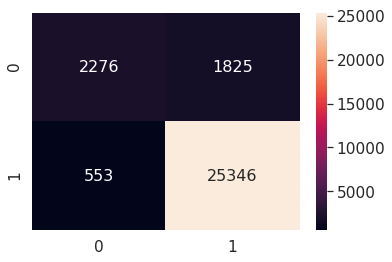

In [19]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

#Bag of Words
count = CountVectorizer() 

X_train = count.fit_transform(X_train)

X_test = count.transform(X_test)

C, penalty = LR(search="Random",X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test)


In [20]:
#Normalize Data
X_train = preprocessing.normalize(X_train)

X_test = preprocessing.normalize(X_test)

### 1.2.2 Word Cloud

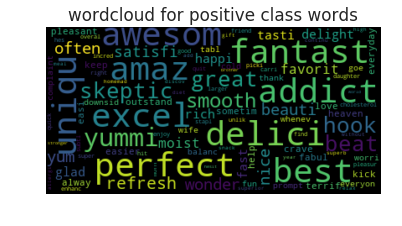

*****************************************************


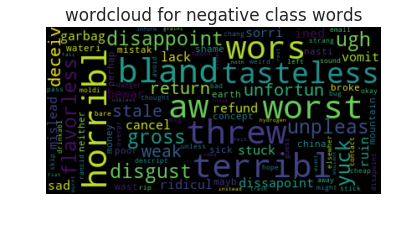

In [21]:
clf = LogisticRegression(C = C, penalty = penalty)
clf.fit(X_train,y_train)
show_cloud(count, clf.coef_)

## 1.3 Sparsity

at C= 0.001
test error= 0.1367
number of non zero element in w= 0
***********************************************
at C= 0.005
test error= 0.1367
number of non zero element in w= 2
***********************************************
at C= 0.01
test error= 0.1367
number of non zero element in w= 10
***********************************************
at C= 0.05
test error= 0.119566666667
number of non zero element in w= 86
***********************************************
at C= 0.1
test error= 0.106766666667
number of non zero element in w= 181
***********************************************
at C= 0.5
test error= 0.0836666666667
number of non zero element in w= 626
***********************************************
at C= 1
test error= 0.0792666666667
number of non zero element in w= 1013
***********************************************
at C= 5
test error= 0.0764666666667
number of non zero element in w= 3238
***********************************************
at C= 10
test error= 0.0793333333333
number of 

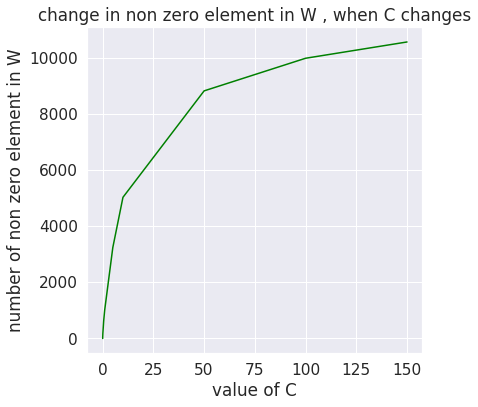

In [22]:
sparsity(X_train=X_train , y_train=y_train , X_test=X_test , y_test=y_test)

## Observation 

    as we increase value of C(decreasing lambda) the sparsity decreases

## 2.TFIDF

### 2.1 Grid

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:  4.0min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy: 92.67%


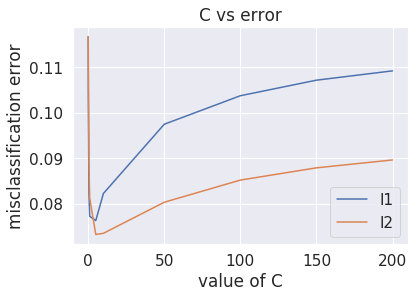

Accuracy on test set: 92.430%
Precision on test set: 0.939
Recall on test set: 0.976
F1-Score on test set: 0.957
Non Zero weights: 31377
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



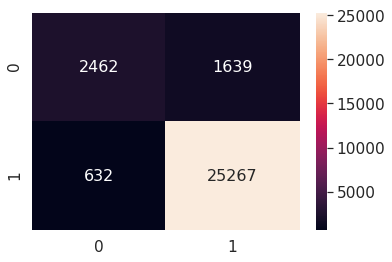

In [23]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

tfidf = TfidfVectorizer(ngram_range=(1,1), binary=True)

X_train = tfidf.fit_transform(X_train)

X_test = tfidf.transform(X_test)

C, penalty =LR(search="Grid",X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [24]:
#Normalize Data
X_train = preprocessing.normalize(X_train)

X_test = preprocessing.normalize(X_test)

### 2.1.1 Perturbation test 

In [25]:
clf = LogisticRegression(C= C, penalty= penalty)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
w=clf.coef_
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.430%
Non Zero weights: 31377


In [26]:
X_train.data=X_train.data+np.random.normal(loc=0,scale=0.01,size=X_train.data.shape) #adding a noise with a very small value

In [27]:
#computing weight after perturbation weight
clf=LogisticRegression(C=C, penalty=penalty)
clf.fit(X_train,y_train)
w_=clf.coef_
print('number of non-zero element in w_=', np.count_nonzero(w_))

number of non-zero element in w_= 31377


In [28]:
#getting the number of elements in w which changes after perturbation test by more than 50%
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>30):
        cnt+=1
print('number of elements in w_delta,more than 30% =',cnt)

number of elements in w_delta,more than 30% = 2114


#### Observation-
* we have 31377 non zero elements in weight before perturbation
* after perturbation test, 2114 elements in weight before perturbation change by more than 30 %
* Thus we can say that the elements weight are collinear

### 2.1.2 Word Cloud Feature Importance

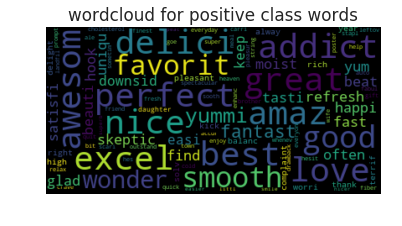

*****************************************************


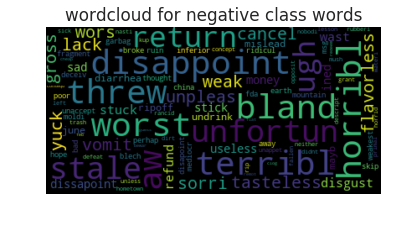

In [29]:
clf = LogisticRegression(C = C, penalty = penalty)
clf.fit(X_train,y_train)
show_cloud(count, clf.coef_)

### 2.2 Random

Train Data Size:  (70000, 31377)
Test Data Size:  (30000, 31377)
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 5}
Best Accuracy: 92.67%


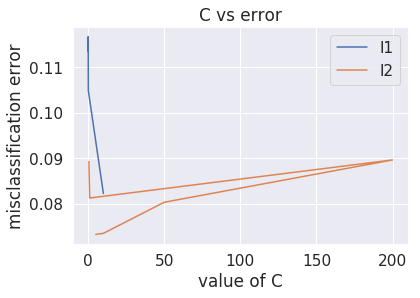

Accuracy on test set: 92.430%
Precision on test set: 0.939
Recall on test set: 0.976
F1-Score on test set: 0.957
Non Zero weights: 31377
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



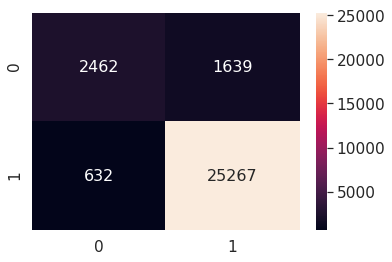

In [30]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

tfidf = TfidfVectorizer(ngram_range=(1,1), binary=True)

X_train = tfidf.fit_transform(X_train)

X_test = tfidf.transform(X_test)

C, penalty = LR(search="Random",X_train = X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### 2.2.1 Word Cloud Feature Importance

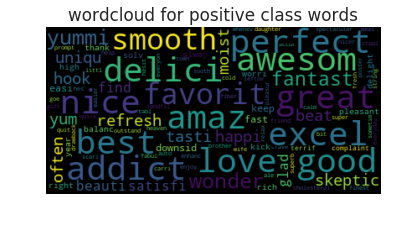

*****************************************************


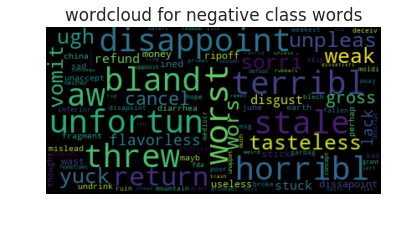

In [31]:
clf = LogisticRegression(C = C, penalty = penalty)
clf.fit(X_train,y_train)
show_cloud(count, clf.coef_)

## 2.3 Sparsity

at C= 0.001
test error= 0.1367
number of non zero element in w= 0
***********************************************
at C= 0.005
test error= 0.1367
number of non zero element in w= 0
***********************************************
at C= 0.01
test error= 0.1367
number of non zero element in w= 4
***********************************************
at C= 0.05
test error= 0.119633333333
number of non zero element in w= 80
***********************************************
at C= 0.1
test error= 0.105733333333
number of non zero element in w= 187
***********************************************
at C= 0.5
test error= 0.0814333333333
number of non zero element in w= 737
***********************************************
at C= 1
test error= 0.0782
number of non zero element in w= 1318
***********************************************
at C= 5
test error= 0.0791666666667
number of non zero element in w= 5086
***********************************************
at C= 10
test error= 0.0841666666667
number of non zero e

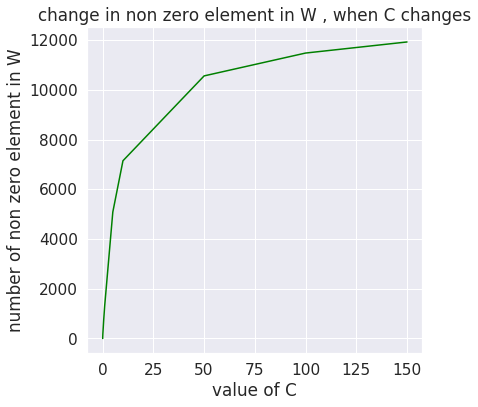

In [32]:
sparsity(X_train=X_train , y_train=y_train , X_test=X_test , y_test=y_test)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

 ## 3.AVG WORD2VEC

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

In [34]:
#url for the GoogleNews word2vec model
url="https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [35]:
import urllib
urllib.request.urlretrieve (url, "GoogleNews-vectors-negative300.bin.gz")

('GoogleNews-vectors-negative300.bin.gz',
 <http.client.HTTPMessage at 0x3ffef3c5fbe0>)

In [36]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [37]:
#loading the GoogleNews word2vec model(able to read bin.gz file directly, no need to extract)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

2018-11-12 06:53:54,090 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2018-11-12 06:56:41,601 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


In [38]:

#getting the list of sentences in a 'list'
i=0

list_of_sentences=[]
for sent in X_train.values:
    filtered_sentence=[]    
    for w in sent.split():
        #w=w.decode('utf-8')
        if (w==sent.split()[0]):
            w=w[2:]
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)
    
print(len(list_of_sentences))

70000


In [39]:
words=list(model.wv.vocab)
print(len(words))

3000000


In [40]:
#calculating avg word2vec
vectors=[];
for sentence in list_of_sentences:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence:
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    vectors.append(sentence_vector)

In [41]:
z=list(np.unique(np.where(np.isnan(vectors))[0]))
z

[]

In [42]:
vectors=np.delete(vectors, z, axis=0)
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)

In [43]:
#calculating avg word2vec
x_test_word=[];
for sentence in X_test.values:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    x_test_word.append(sentence_vector)

    
print(len(x_test_word))

30000


In [44]:
#checking row containing nan value
z=list(np.unique(np.where(np.isnan(x_test_word))[0]))
z

[]

In [45]:
#deleting row containing nan value
x_test_word=np.delete(x_test_word, z, axis=0)
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)

### 3.1  Grid

Train Data Size:  (70000, 300)
Test Data Size:  (30000, 300)
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 31.5min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l1'}
Best Accuracy: 90.07%


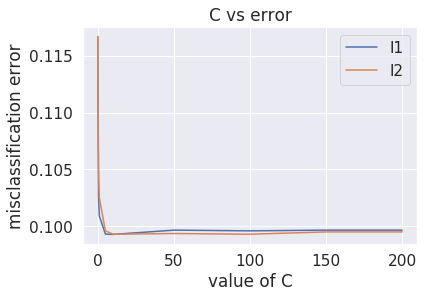

Accuracy on test set: 89.007%
Precision on test set: 0.903
Recall on test set: 0.978
F1-Score on test set: 0.939
Non Zero weights: 293
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



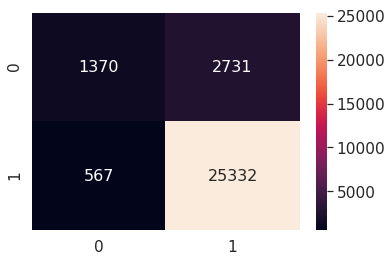

In [46]:
C, penalty = LR(search="Grid",X_train = vectors, X_test=x_test_word, y_train=y_train, y_test=y_test)

In [47]:
#Normalize Data
X_train = preprocessing.normalize(vectors)

X_test = preprocessing.normalize(x_test_word)

### 3.1.1 Perturbation test 

In [48]:
clf = LogisticRegression(C= C, penalty= penalty)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
w=clf.coef_
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.010%
Non Zero weights: 293


In [49]:
X_train.data = X_train.data + np.random.normal(loc=0,scale=0.1,size=X_train.shape) #adding a noise with a very small value

In [50]:
#computing weight after perturbation weight
clf=LogisticRegression(C=C, penalty=penalty)
clf.fit(X_train,y_train)
w_=clf.coef_
print('number of non-zero element in w_=', np.count_nonzero(w_))

number of non-zero element in w_= 298


In [51]:
#getting the number of elements in w which changes after perturbation test by more than 50%
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>30):
        cnt+=1
print('number of elements in w_delta,more than 30% =',cnt)

number of elements in w_delta,more than 30% = 290


#### Observation-
* we have 300 non zero elements in weight before perturbation
* after perturbation test, 290 elements in weight before perturbation change by more than 30 %
* Thus we can say that elements weight are collinear

### 3.2 Random 

Train Data Size:  (70000, 300)
Test Data Size:  (30000, 300)
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 15.5min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 90.07%


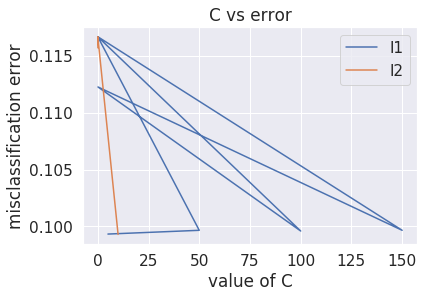

Accuracy on test set: 88.993%
Precision on test set: 0.902
Recall on test set: 0.979
F1-Score on test set: 0.939
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



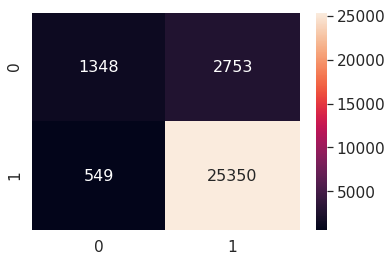

In [52]:
C, penalty = LR(search="Random",X_train = vectors, X_test=x_test_word, y_train=y_train, y_test=y_test)

## 3.3 Sparsity

at C= 0.001
test error= 0.1367
number of non zero element in w= 0
***********************************************
at C= 0.005
test error= 0.1367
number of non zero element in w= 0
***********************************************
at C= 0.01
test error= 0.1367
number of non zero element in w= 7
***********************************************
at C= 0.05
test error= 0.131133333333
number of non zero element in w= 76
***********************************************
at C= 0.1
test error= 0.123733333333
number of non zero element in w= 125
***********************************************
at C= 0.5
test error= 0.115233333333
number of non zero element in w= 233
***********************************************
at C= 1
test error= 0.114066666667
number of non zero element in w= 261
***********************************************
at C= 5
test error= 0.113166666667
number of non zero element in w= 295
***********************************************
at C= 10
test error= 0.112733333333
number of non zer

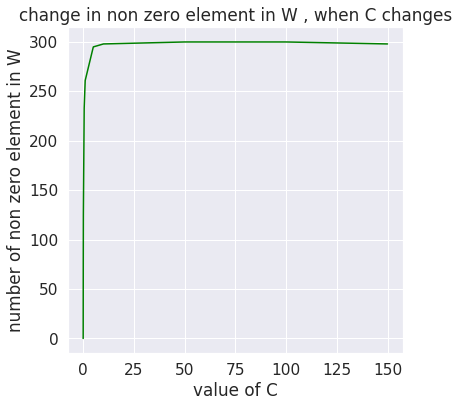

In [53]:
sparsity(X_train = vectors, X_test= x_test_word, y_train=y_train, y_test=y_test)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

## 4. TFDIF WORD2VEC

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=False,random_state=0)

tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X_train.values)
x_test_tfidf=tfidf.transform(X_test.values)

#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [68]:
features=tfidf.get_feature_names()
len(features)

31377

In [79]:
#calculating tf-idf w2vec
tfidf_vectors = []; 
row=0;
for sentence in list_of_sentences: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence: 
        try:
            vec = model.wv[word]
            tf_idf = x_train_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    tfidf_vectors.append(sentence_vec)
    row += 1
    
print(len(tfidf_vectors))

70000


In [81]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
z

[1622, 1695, 11064, 55871, 60700]

In [82]:

y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)
tfidf_vectors=np.delete(tfidf_vectors, z, axis=0)



In [83]:
print(len(tfidf_vectors))

69995


In [73]:
#calculating tf-idf w2vec
x_test_tf_word = []; 
row=0;
for sentence in X_test.values: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        
        try:
            vec = model.wv[word]
            tf_idf = x_test_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    x_test_tf_word.append(sentence_vec)
    row += 1

In [74]:
print(len(x_test_tf_word))

30000


In [75]:
z=list(np.unique(np.where(np.isnan(x_test_tf_word))[0]))
z

[]

In [76]:
x_test_tf_word=np.delete(x_test_tf_word, z , axis=0)
len(x_test_tf_word)

30000

In [77]:
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)
len(x_test_word)

30000

### 4.1  Grid 

Train Data Size:  (69995, 300)
Test Data Size:  (30000, 300)
Fitting 10 folds for each of 26 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 21.6min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 89.46%


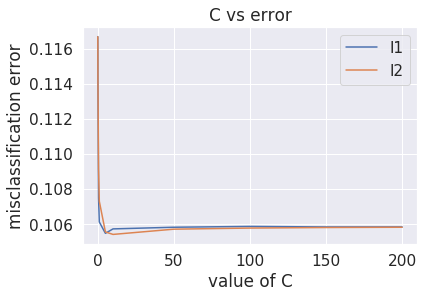

Accuracy on test set: 87.830%
Precision on test set: 0.889
Recall on test set: 0.982
F1-Score on test set: 0.933
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



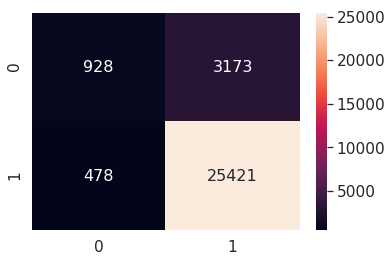

In [86]:
C, penalty = LR(search="Grid",X_train = tfidf_vectors, X_test = x_test_tf_word, y_train = y_train_word, y_test = y_test)

In [87]:
#Normalize Data
X_train = preprocessing.normalize(tfidf_vectors)

#Normalize Data
X_test = preprocessing.normalize(x_test_tf_word)



### 4.1.1 Perturbation test 

In [88]:
clf = LogisticRegression(C = C, penalty = penalty)
clf.fit(X_train,y_train_word)
y_pred = clf.predict(X_test)
w=clf.coef_
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.830%
Non Zero weights: 300


In [89]:
X_train.data=X_train.data+np.random.normal(loc=0,scale=0.1,size=X_train.data.shape) #adding a noise with a very small value

In [90]:
#computing weight after perturbation weight
clf=LogisticRegression(C=C, penalty=penalty)
clf.fit(X_train,y_train_word)
w_=clf.coef_
print('number of non-zero element in w_=', np.count_nonzero(w_))

number of non-zero element in w_= 300


In [91]:
#getting the number of elements in w which changes after perturbation test by more than 50%
w_delta=abs((w-w_)/w)*100
cnt=0
for i in range(len(w_delta[0])):
    if (w_delta[0][i]>50):
        cnt+=1
print('number of elements in w_delta,more than 50% =',cnt)

number of elements in w_delta,more than 50% = 272


#### Observation-
* we have 300 non zero elements in weight before perturbation
* after perturbation test, 272 elements in weight before perturbation change by more than 30 %
* we can say that it is collinear

### 4.2 Random  

Train Data Size:  (69995, 300)
Test Data Size:  (30000, 300)
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  8.4min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 89.46%


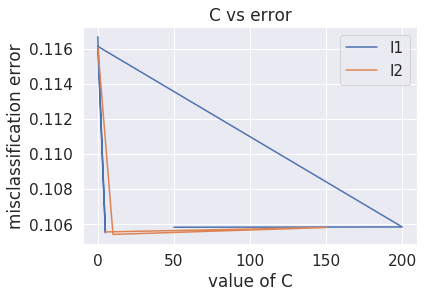

Accuracy on test set: 87.830%
Precision on test set: 0.889
Recall on test set: 0.982
F1-Score on test set: 0.933
Non Zero weights: 300
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



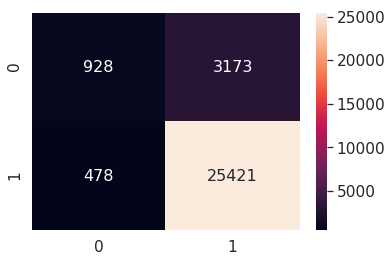

In [92]:

C, penalty = LR(search="Random",X_train = tfidf_vectors, X_test = x_test_tf_word, y_train = y_train_word, y_test = y_test)


## 4.3 Sparsity

at C= 0.001
test error= 0.1367
number of non zero element in w= 0
***********************************************
at C= 0.005
test error= 0.1367
number of non zero element in w= 0
***********************************************
at C= 0.01
test error= 0.1367
number of non zero element in w= 6
***********************************************
at C= 0.05
test error= 0.134666666667
number of non zero element in w= 102
***********************************************
at C= 0.1
test error= 0.1313
number of non zero element in w= 151
***********************************************
at C= 0.5
test error= 0.1262
number of non zero element in w= 259
***********************************************
at C= 1
test error= 0.125233333333
number of non zero element in w= 279
***********************************************
at C= 5
test error= 0.1251
number of non zero element in w= 298
***********************************************
at C= 10
test error= 0.125066666667
number of non zero element in w= 297
***

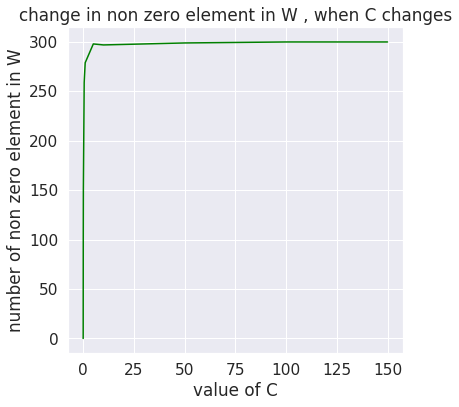

In [94]:
sparsity(X_train = tfidf_vectors, X_test = x_test_tf_word, y_train = y_train_word, y_test = y_test)

#### Observation-
* as we increase value of C(decreasing lambda) the sparsity decreases

# Performance Table

![title](Slide_0.jpg)

## Observation 
* we have taken amazon fine food review and applied logistic regression model using BoW, Tfidf, Avg word2vec and Tfidf word2vec.
* the Accuracy comes for tfidf and bag of words is fairly good.
* in the final table we can see that Logistic regression works well for BOW and TFIDF, but not good in case of avg word2vec and tfidf word2vec.
* we can conclude that logistic regression works fairly well if dimension is high